In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Project paths
PROJECT_DIR = Path("..").resolve()
DATA_RAW = PROJECT_DIR / "data" / "raw"
DATA_PROCESSED = PROJECT_DIR / "data" / "processed"
FIG_DIR = PROJECT_DIR / "outputs" / "figures"

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
df = pd.read_csv(DATA_RAW / "wheat_climate.csv")
df.head(), df.shape

(   year    country code  yield_kg_ha  tas_gs_mean  pr_gs_sum
 0  2000  Argentina  ARG         2650         16.2        480
 1  2001  Argentina  ARG         2410         15.8        430
 2  2002  Argentina  ARG         2780         16.5        510
 3  2003  Argentina  ARG         2520         16.0        455
 4  2004  Argentina  ARG         2900         16.7        525,
 (15, 6))

In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         15 non-null     int64  
 1   country      15 non-null     object 
 2   code         15 non-null     object 
 3   yield_kg_ha  15 non-null     int64  
 4   tas_gs_mean  15 non-null     float64
 5   pr_gs_sum    15 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 852.0+ bytes


,year,yield_kg_ha,tas_gs_mean,pr_gs_sum
count,15.00000,15.000000,15.000000,15.000000
mean,2002.00000,4147.333333,14.706667,494.666667
std,1.46385,2086.714666,1.325824,75.603918
min,2000.00000,2410.000000,12.800000,380.000000
25%,2001.00000,2675.000000,13.750000,442.500000
50%,2002.00000,2900.000000,14.500000,480.000000
75%,2003.00000,6650.000000,15.900000,532.500000
max,2004.00000,7350.000000,16.700000,630.000000


In [6]:
TARGET = "yield_kg_ha"
assert TARGET in df.columns
df[TARGET].describe()

count      15.000000
mean     4147.333333
std      2086.714666
min      2410.000000
25%      2675.000000
50%      2900.000000
75%      6650.000000
max      7350.000000
Name: yield_kg_ha, dtype: float64

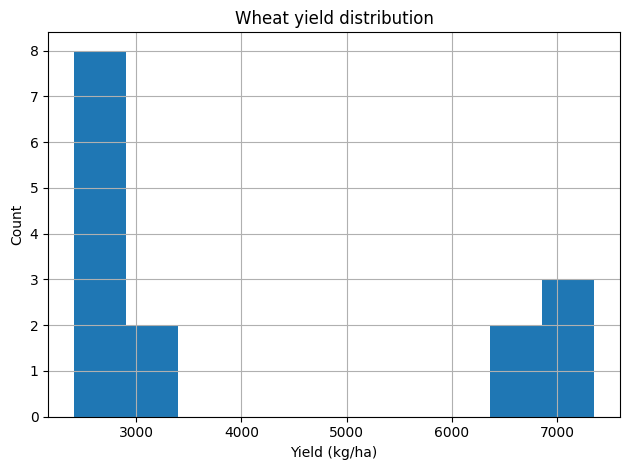

In [7]:
plt.figure()
df[TARGET].hist(bins=10)
plt.xlabel("Yield (kg/ha)")
plt.ylabel("Count")
plt.title("Wheat yield distribution")
plt.tight_layout()
plt.savefig(FIG_DIR / "yield_distribution.png", dpi=200)
plt.show()

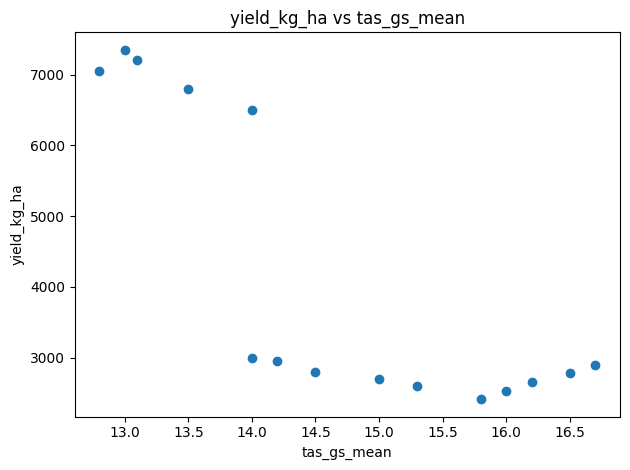

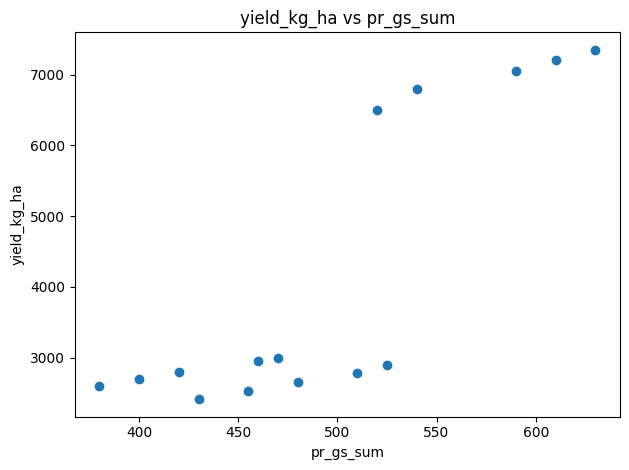

In [8]:
for col in ["tas_gs_mean", "pr_gs_sum"]:
    plt.figure()
    plt.scatter(df[col], df[TARGET])
    plt.xlabel(col)
    plt.ylabel(TARGET)
    plt.title(f"{TARGET} vs {col}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"scatter_{col}.png", dpi=200)
    plt.show()

In [9]:
df.isna().mean() * 100

year           0.0
country        0.0
code           0.0
yield_kg_ha    0.0
tas_gs_mean    0.0
pr_gs_sum      0.0
dtype: float64

In [10]:
df_clean = df.dropna(subset=[TARGET]).copy()

num_cols = df_clean.select_dtypes(include=np.number).columns
df_clean = df_clean[num_cols]

df_clean.head(), df_clean.shape

(   year  yield_kg_ha  tas_gs_mean  pr_gs_sum
 0  2000         2650         16.2        480
 1  2001         2410         15.8        430
 2  2002         2780         16.5        510
 3  2003         2520         16.0        455
 4  2004         2900         16.7        525,
 (15, 4))

In [11]:
out_path = DATA_PROCESSED / "wheat_climate_clean.csv"
df_clean.to_csv(out_path, index=False)

out_path

PosixPath('/Users/nicolepretini/PycharmProjects/wheat-yield-climate-ml/data/processed/wheat_climate_clean.csv')

In [12]:
df_clean.describe()

,year,yield_kg_ha,tas_gs_mean,pr_gs_sum
count,15.00000,15.000000,15.000000,15.000000
mean,2002.00000,4147.333333,14.706667,494.666667
std,1.46385,2086.714666,1.325824,75.603918
min,2000.00000,2410.000000,12.800000,380.000000
25%,2001.00000,2675.000000,13.750000,442.500000
50%,2002.00000,2900.000000,14.500000,480.000000
75%,2003.00000,6650.000000,15.900000,532.500000
max,2004.00000,7350.000000,16.700000,630.000000


In [13]:
df.columns.tolist()

['year', 'country', 'code', 'yield_kg_ha', 'tas_gs_mean', 'pr_gs_sum']

In [16]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

PROJECT_DIR = Path("..").resolve()
df = pd.read_csv(PROJECT_DIR / "data" / "processed" / "wheat_climate_clean.csv")

X = df[["tas_gs_mean", "pr_gs_sum"]]
y = df["yield_kg_ha"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

import numpy as np

rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

rmse_dummy, rmse_ridge

(np.float64(2309.072541086572), np.float64(742.6389957199926))

In [17]:
rmse_dummy = float(rmse_dummy)
rmse_ridge = float(rmse_ridge)
print(f"RMSE Dummy: {rmse_dummy:.2f}")
print(f"RMSE Ridge: {rmse_ridge:.2f}")

RMSE Dummy: 2309.07
RMSE Ridge: 742.64


In [18]:
import pandas as pd
from pathlib import Path

PROJECT_DIR = Path("..").resolve()
TABLE_DIR = PROJECT_DIR / "outputs" / "tables"
TABLE_DIR.mkdir(parents=True, exist_ok=True)

results = pd.DataFrame({
    "model": ["DummyMean", "Ridge"],
    "rmse": [float(rmse_dummy), float(rmse_ridge)]
})

results

,model,rmse
0,DummyMean,2309.072541
1,Ridge,742.638996


In [19]:
results_path = TABLE_DIR / "baseline_results.csv"
results.to_csv(results_path, index=False)
results_path

PosixPath('/Users/nicolepretini/PycharmProjects/wheat-yield-climate-ml/outputs/tables/baseline_results.csv')

In [20]:
import joblib

MODEL_DIR = PROJECT_DIR / "outputs" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODEL_DIR / "ridge.joblib"
joblib.dump(ridge, model_path)

model_path

PosixPath('/Users/nicolepretini/PycharmProjects/wheat-yield-climate-ml/outputs/models/ridge.joblib')